<a href="https://www.kaggle.com/code/nargles/fruit-photo-analysis?scriptVersionId=128829543" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

images = []
imagesByCategory = {}

main_directory = '/kaggle/input/fruits-dataset-images/images/'
main_directory_glob = '/kaggle/input/fruits-dataset-images/images/*/*'

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        images.append(os.path.join(dirname, filename))
        
        ls = dirname.split('/')
        if(ls[-1] not in imagesByCategory):
            imagesByCategory[ls[-1]] = [os.path.join(dirname, filename)]
        else:
            imagesByCategory[ls[-1]].append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


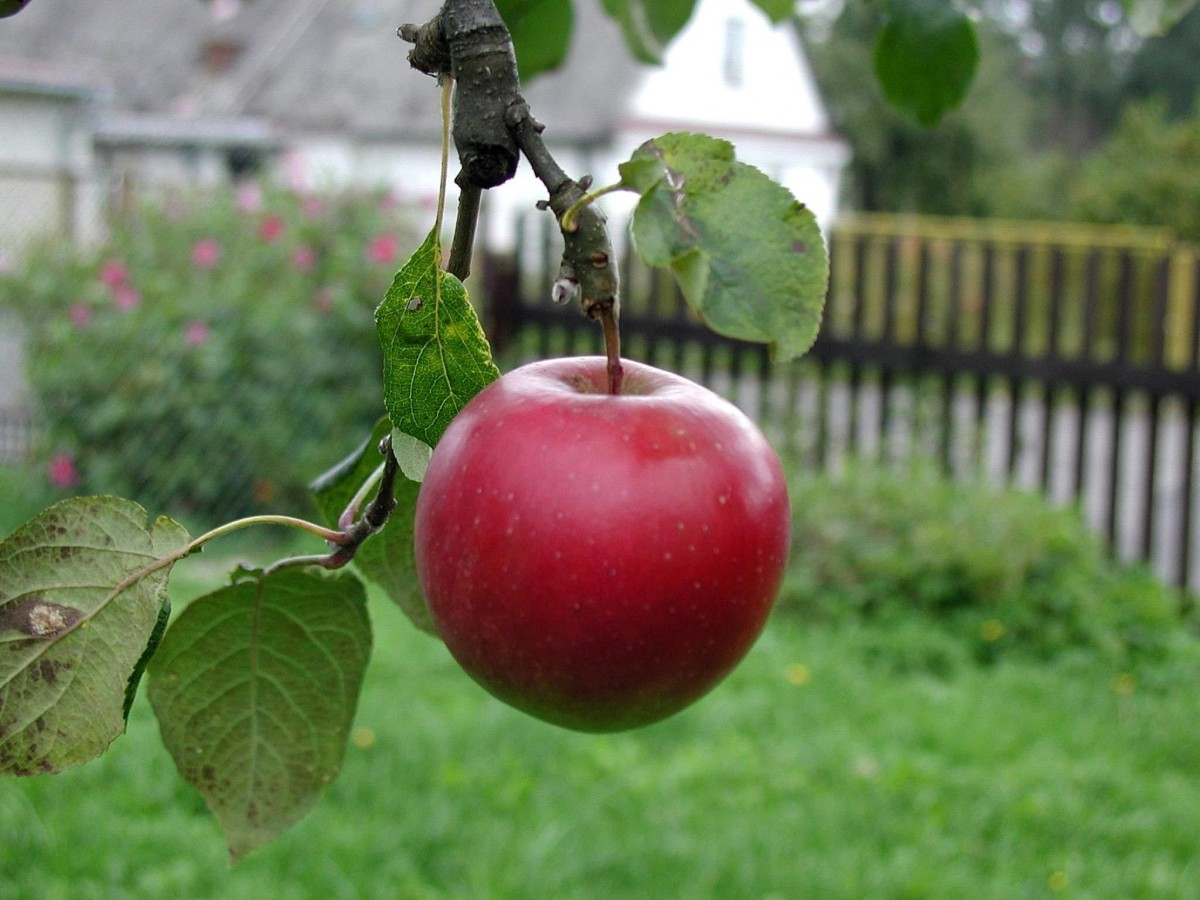

In [2]:
# We are able to open an image to take a look at it.
PIL.Image.open(str(images[0]))

In [3]:
# Define some hyperparameters
batch_size = 32
img_height = 180
img_width = 180

num_classes = 9
kernel_size = 3
epochs = 25

# Set the seed 
seed = 1119

# Seed value for TensorFlow
tf.random.set_seed(seed)

# Seed value for NumPy
np.random.seed(seed)

# Seed value for Python's random library
random.seed(seed)

In [4]:
# Use Keras to define the data and create the tensors for us
# Default functionality is to shuffle the data so no need to worry about that.
print("~~~Create Training Data~~~")
ds_train = tf.keras.utils.image_dataset_from_directory(
  main_directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
print('')
print("~~~Create Testing Data~~~")
ds_test = tf.keras.utils.image_dataset_from_directory(
  main_directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

~~~Create Training Data~~~
Found 360 files belonging to 9 classes.
Using 288 files for training.

~~~Create Testing Data~~~
Found 360 files belonging to 9 classes.
Using 72 files for validation.


In [5]:
# Let us peek into the class names that we have extracted.
# This will match the directory name the files live in.
class_names = ds_train.class_names
print(class_names)

['apple fruit', 'banana fruit', 'cherry fruit', 'chickoo fruit', 'grapes fruit', 'kiwi fruit', 'mango fruit', 'orange fruit', 'strawberry fruit']


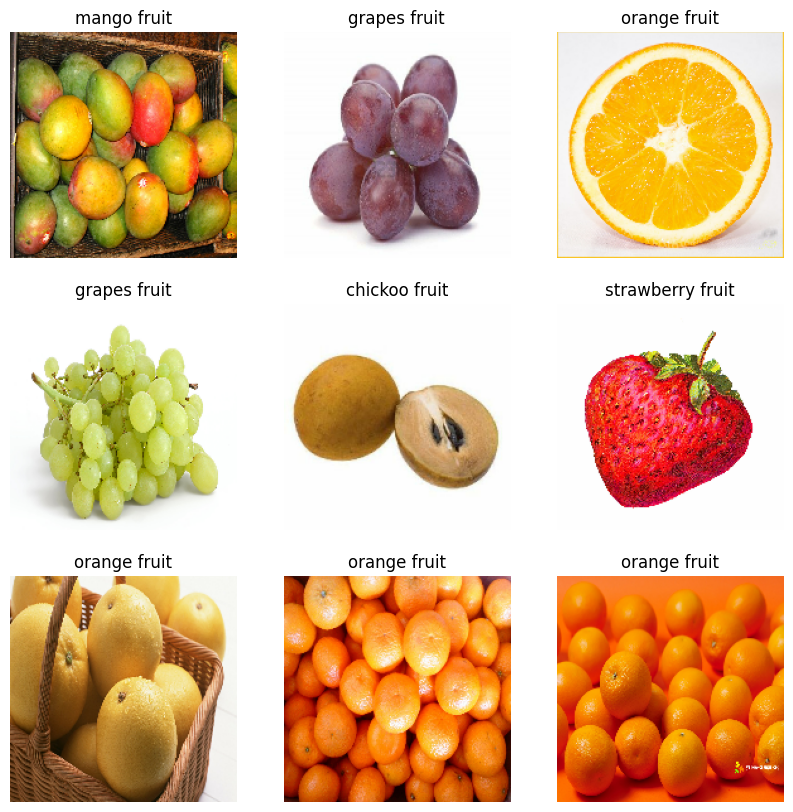

In [6]:
import matplotlib.pyplot as plt


# Here we plot an example image for each directory.
plt.figure(figsize=(10,10))
for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
#Information about the shape of the tensor created. 
#These should match the hyper parameters defined above. 
for image_batch, labels_batch in ds_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [8]:
#RGB has channel values of 255.
#We need to normalize the values to make it easier to compute.

normalization_layer = tf.keras.layers.Rescaling(1./255)

#See what happens with you follow this note
#Note: If you would like to scale pixel values to [-1,1] 
#      you can instead write tf.keras.layers.Rescaling(1./127.5, offset=-1)

#You can also add a manual resizing layer here instead of on import using
#    tf.keras.layers.Resizing layer

In [9]:
#Information about the first image and its normalized form.
ds_normalized = ds_train.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(ds_normalized))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0022535457 1.0


In [10]:
# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Let us build the sequential model.
# First, rescalse the image.
# Second, pass the image through 3 Conv2d into MaxPooling2d blocks.
# Finish with a Flatten and Dense so the NN can process things
mainModel = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [12]:
#Compile the model with an adam optimizer.
#For some reason, everyone uses the adam optimizer. Needs more research.
#We implement a loss function called Sparse Categorical Cross Entropy.
#We do so because it does something at the boundaries of each category.
#This allows us to get the results we are looking for. More reasearch is needed.
mainModel.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
#We train the model over 3 epochs.
#Adjusting hyper params and # of epochs will alter performance
main_history = mainModel.fit(ds_train, validation_data=ds_test, epochs=epochs)

#After several runs, we get the following results:
#loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.1000 - val_accuracy: 0.5972

#We are running into the issue that our model is overfitted.

#We must explore ways to reduce this undesired outcome.


Epoch 1/25
9/9 [==============================] - 23s 342ms/step - loss: 2.2022 - accuracy: 0.0972 - val_loss: 2.0911 - val_accuracy: 0.2222
Epoch 2/25
9/9 [==============================] - 0s 33ms/step - loss: 1.8765 - accuracy: 0.2986 - val_loss: 1.6539 - val_accuracy: 0.4583
Epoch 3/25
9/9 [==============================] - 0s 24ms/step - loss: 1.3950 - accuracy: 0.4896 - val_loss: 1.3705 - val_accuracy: 0.5139
Epoch 4/25
9/9 [==============================] - 0s 24ms/step - loss: 1.0816 - accuracy: 0.6493 - val_loss: 1.2627 - val_accuracy: 0.5278
Epoch 5/25
9/9 [==============================] - 0s 25ms/step - loss: 0.7936 - accuracy: 0.7778 - val_loss: 1.2246 - val_accuracy: 0.5417
Epoch 6/25
9/9 [==============================] - 0s 25ms/step - loss: 0.5683 - accuracy: 0.8681 - val_loss: 1.1773 - val_accuracy: 0.5694
Epoch 7/25
9/9 [==============================] - 0s 25ms/step - loss: 0.4687 - accuracy: 0.8785 - val_loss: 1.7467 - val_accuracy: 0.4583
Epoch 8/25
9/9 [=========

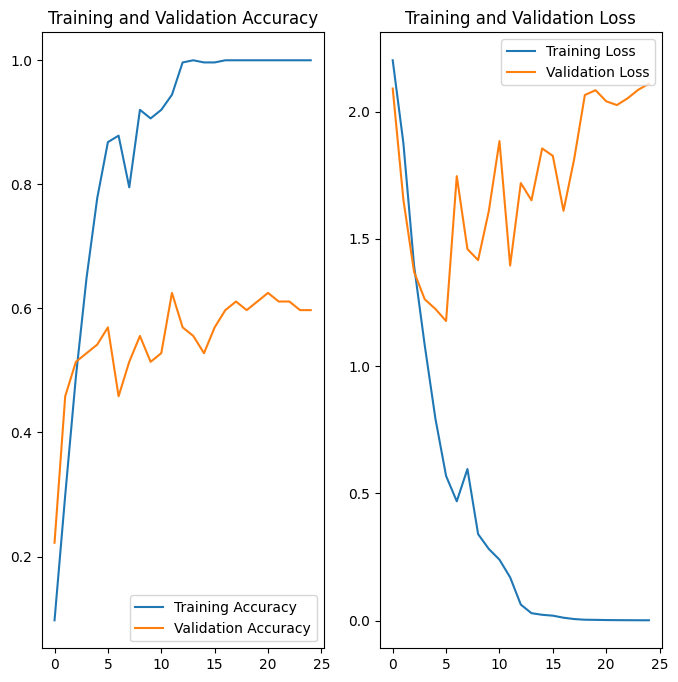

In [14]:
acc = main_history.history['accuracy']
val_acc = main_history.history['val_accuracy']

loss = main_history.history['loss']
val_loss = main_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Overfit

We have a few approaches we can take:
* Add more data
* Data Augmentation
* Dropout layers for regularization
* Combination of the three

In [15]:
# Here we are flipping the image and applying a random rotation.

# I am defining the preprocessing layer for data augmentation

preprocessing_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

### Adding more data

I do not have more access to data. I cannot show the outcomes. You can enjoy previous attempts that combined data augmentation to create data. 

This is not ideal. It also did not help the training of the model. 


In [16]:
#Let us make more training data

ds_aug = ds_train.map(lambda x, y: (preprocessing_layer(x, training=True), y))
ds_combine_train = ds_aug.concatenate(ds_train)
for i in range(6):
    ds_aug = ds_train.map(lambda x, y: (preprocessing_layer(x, training=True), y))
    ds_combine_train = ds_combine_train.concatenate(ds_aug)
    ds_aug = ds_train.map(lambda x, y: (preprocessing_layer(x, training=True), y))
    ds_combine_train = ds_combine_train.concatenate(ds_aug)

ds_combine_train

<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
#Let us make more validation data

ds_aug = ds_test.map(lambda x, y: (preprocessing_layer(x, training=True), y))
ds_combine_test = ds_aug.concatenate(ds_test)
for i in range(6):
    ds_aug = ds_test.map(lambda x, y: (preprocessing_layer(x, training=True), y))
    ds_combine_test = ds_aug.concatenate(ds_combine_test)
    ds_aug = ds_test.map(lambda x, y: (preprocessing_layer(x, training=True), y))
    ds_combine_test = ds_aug.concatenate(ds_combine_test)

ds_combine_test

<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
dataAddedmodel = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])


In [19]:
dataAddedmodel.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
history_data_added = dataAddedmodel.fit(ds_combine_train, validation_data=ds_combine_test, epochs=epochs)

Epoch 1/25
126/126 [==============================] - 42s 322ms/step - loss: 1.2527 - accuracy: 0.5330 - val_loss: 1.4426 - val_accuracy: 0.5060
Epoch 2/25
126/126 [==============================] - 36s 289ms/step - loss: 0.5918 - accuracy: 0.7805 - val_loss: 1.4222 - val_accuracy: 0.6200
Epoch 3/25
126/126 [==============================] - 37s 292ms/step - loss: 0.3278 - accuracy: 0.8837 - val_loss: 1.7217 - val_accuracy: 0.5933
Epoch 4/25
126/126 [==============================] - 36s 289ms/step - loss: 0.2176 - accuracy: 0.9253 - val_loss: 1.9412 - val_accuracy: 0.5972
Epoch 5/25
126/126 [==============================] - 37s 293ms/step - loss: 0.1188 - accuracy: 0.9623 - val_loss: 2.6619 - val_accuracy: 0.6042
Epoch 6/25
126/126 [==============================] - 37s 293ms/step - loss: 0.1107 - accuracy: 0.9645 - val_loss: 2.5656 - val_accuracy: 0.5893
Epoch 7/25
126/126 [==============================] - 37s 292ms/step - loss: 0.0864 - accuracy: 0.9727 - val_loss: 2.6498 - val_ac

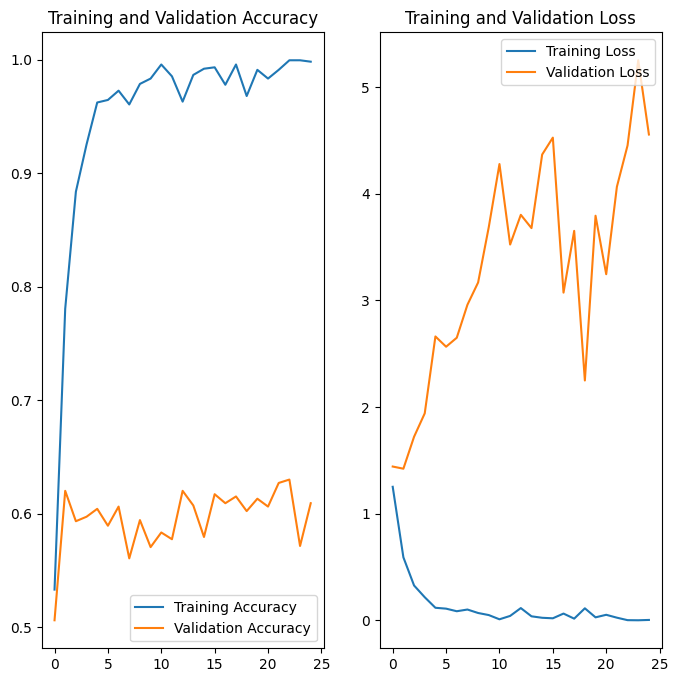

In [21]:
acc = history_data_added.history['accuracy']
val_acc = history_data_added.history['val_accuracy']

loss = history_data_added.history['loss']
val_loss = history_data_added.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Data Augmentation


In [22]:
dataAugmentedmodel = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    preprocessing_layer,
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])


In [23]:
dataAugmentedmodel.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
aug_history = dataAugmentedmodel.fit(ds_train, validation_data=ds_test, epochs=epochs)

Epoch 1/25
9/9 [==============================] - 7s 185ms/step - loss: 2.2200 - accuracy: 0.1771 - val_loss: 2.0186 - val_accuracy: 0.1667
Epoch 2/25
9/9 [==============================] - 1s 166ms/step - loss: 1.8605 - accuracy: 0.2778 - val_loss: 1.7595 - val_accuracy: 0.2500
Epoch 3/25
9/9 [==============================] - 1s 155ms/step - loss: 1.6013 - accuracy: 0.3194 - val_loss: 1.5823 - val_accuracy: 0.3472
Epoch 4/25
9/9 [==============================] - 1s 161ms/step - loss: 1.3969 - accuracy: 0.4688 - val_loss: 2.0114 - val_accuracy: 0.2500
Epoch 5/25
9/9 [==============================] - 1s 158ms/step - loss: 1.2317 - accuracy: 0.5729 - val_loss: 2.0067 - val_accuracy: 0.3333
Epoch 6/25
9/9 [==============================] - 1s 157ms/step - loss: 1.2347 - accuracy: 0.5417 - val_loss: 1.4257 - val_accuracy: 0.5556
Epoch 7/25
9/9 [==============================] - 1s 159ms/step - loss: 1.1281 - accuracy: 0.5938 - val_loss: 1.5219 - val_accuracy: 0.4028
Epoch 8/25
9/9 [====

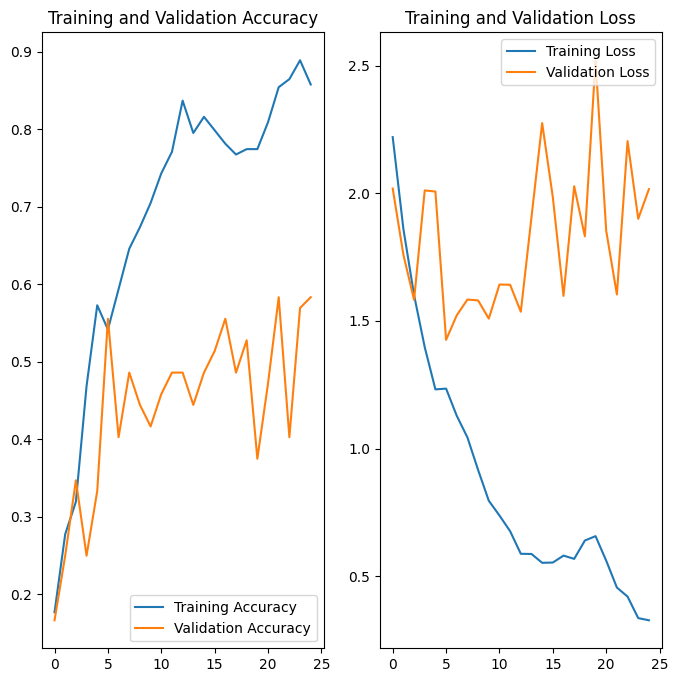

In [25]:
acc = aug_history.history['accuracy']
val_acc = aug_history.history['val_accuracy']

loss = aug_history.history['loss']
val_loss = aug_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Conclusion

The given a long enough training window, and possibly more sporadic augmentations. 

We can expect to see the validation accuracy trend upwards, but unfor

### Dropout layer added

In [26]:
dataDropoutmodel = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])


In [27]:
dataDropoutmodel.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
dropout_history = dataDropoutmodel.fit(ds_train, validation_data=ds_test, epochs=epochs)

Epoch 1/25


2023-05-09 01:41:52.978809: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 2s 66ms/step - loss: 2.1876 - accuracy: 0.1493 - val_loss: 2.0923 - val_accuracy: 0.1250
Epoch 2/25
9/9 [==============================] - 0s 42ms/step - loss: 1.8901 - accuracy: 0.2535 - val_loss: 1.7444 - val_accuracy: 0.3611
Epoch 3/25
9/9 [==============================] - 0s 44ms/step - loss: 1.4667 - accuracy: 0.4618 - val_loss: 1.5441 - val_accuracy: 0.4167
Epoch 4/25
9/9 [==============================] - 0s 41ms/step - loss: 1.1997 - accuracy: 0.5868 - val_loss: 1.4399 - val_accuracy: 0.4722
Epoch 5/25
9/9 [==============================] - 0s 41ms/step - loss: 0.9170 - accuracy: 0.7188 - val_loss: 1.3934 - val_accuracy: 0.5278
Epoch 6/25
9/9 [==============================] - 0s 41ms/step - loss: 0.7237 - accuracy: 0.7674 - val_loss: 1.3540 - val_accuracy: 0.5694
Epoch 7/25
9/9 [==============================] - 0s 41ms/step - loss: 0.5688 - accuracy: 0.8438 - val_loss: 1.2480 - val_accuracy: 0.5556
Epoch 8/25
9/9 [======================

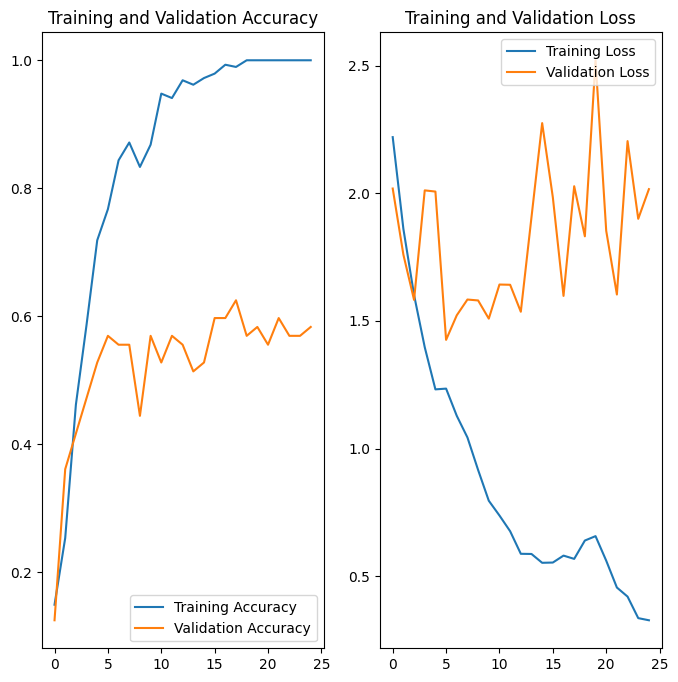

In [29]:
acc = dropout_history.history['accuracy']
val_acc = dropout_history.history['val_accuracy']

loss = aug_history.history['loss']
val_loss = aug_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### All together now

In [30]:
#Let us make more training data

ds_aug = ds_train.map(lambda x, y: (preprocessing_layer(x, training=True), y))
ds_combine_train = ds_aug.concatenate(ds_train)
for i in range(6):
    ds_aug = ds_train.map(lambda x, y: (preprocessing_layer(x, training=True), y))
    ds_combine_train = ds_combine_train.concatenate(ds_aug)
    ds_aug = ds_train.map(lambda x, y: (preprocessing_layer(x, training=True), y))
    ds_combine_train = ds_combine_train.concatenate(ds_aug)

ds_combine_train

<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [31]:
#Let us make more validation data

ds_aug = ds_test.map(lambda x, y: (preprocessing_layer(x, training=True), y))
ds_combine_test = ds_aug.concatenate(ds_test)
for i in range(6):
    ds_aug = ds_test.map(lambda x, y: (preprocessing_layer(x, training=True), y))
    ds_combine_test = ds_aug.concatenate(ds_combine_test)
    ds_aug = ds_test.map(lambda x, y: (preprocessing_layer(x, training=True), y))
    ds_combine_test = ds_aug.concatenate(ds_combine_test)

ds_combine_test

<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [32]:
dataAllmodel = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    preprocessing_layer,
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])


In [33]:
dataAllmodel.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
history_data_all = dataAllmodel.fit(ds_combine_train, validation_data=ds_combine_test, epochs=epochs)

Epoch 1/25


2023-05-09 01:42:43.177995: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


126/126 [==============================] - 59s 434ms/step - loss: 1.3459 - accuracy: 0.4797 - val_loss: 1.3521 - val_accuracy: 0.5466
Epoch 2/25
126/126 [==============================] - 51s 406ms/step - loss: 0.7004 - accuracy: 0.7401 - val_loss: 1.4418 - val_accuracy: 0.6181
Epoch 3/25
126/126 [==============================] - 51s 403ms/step - loss: 0.3772 - accuracy: 0.8661 - val_loss: 1.9969 - val_accuracy: 0.6002
Epoch 4/25
126/126 [==============================] - 51s 408ms/step - loss: 0.2568 - accuracy: 0.9105 - val_loss: 2.1816 - val_accuracy: 0.5724
Epoch 5/25
126/126 [==============================] - 51s 407ms/step - loss: 0.2330 - accuracy: 0.9191 - val_loss: 2.4296 - val_accuracy: 0.5754
Epoch 6/25
126/126 [==============================] - 50s 398ms/step - loss: 0.1193 - accuracy: 0.9601 - val_loss: 2.3791 - val_accuracy: 0.6141
Epoch 7/25
126/126 [==============================] - 51s 405ms/step - loss: 0.1860 - accuracy: 0.9345 - val_loss: 3.0007 - val_accuracy: 0.5

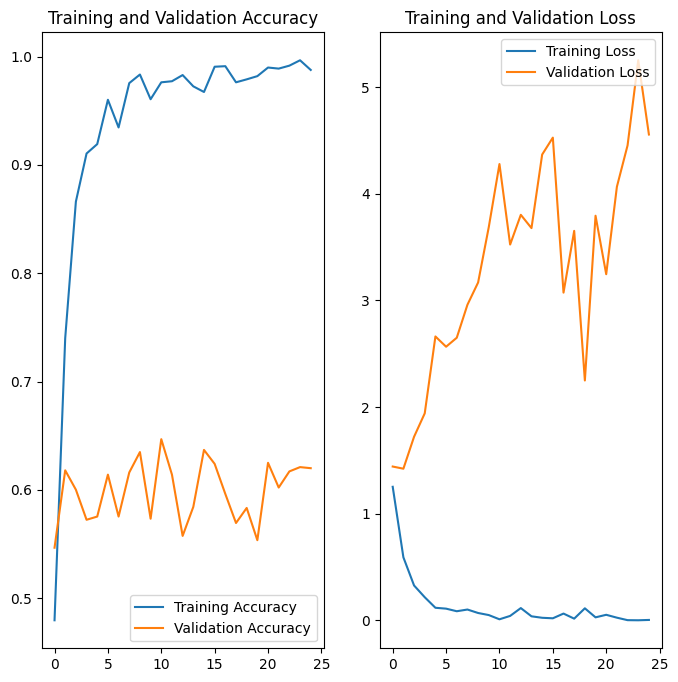

In [35]:
acc = history_data_all.history['accuracy']
val_acc = history_data_all.history['val_accuracy']

loss = history_data_added.history['loss']
val_loss = history_data_added.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()